# Regularisation for Inverse Problems

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage import data
from scipy.signal import convolve2d as conv2
from skimage.util import random_noise
from skimage.restoration import wiener, richardson_lucy

# helper function
def plot_images(images, titles, fname=[], scale = [0,1]):
    m = len(images)
    fig, ax = plt.subplots(1,m)
    
    if m > 1:
        for k in range(m):
            ax[k].set_xticks([])
            ax[k].set_yticks([])
            ax[k].imshow(images[k], cmap=plt.cm.gray, vmin=scale[0], vmax=scale[1])
            ax[k].set_title(titles[k])
    else:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(images[0], cmap=plt.cm.gray, vmin=scale[0], vmax=scale[1])
        ax.set_title(titles[0])
    fig.set_figwidth(10)
    fig.tight_layout()
    
    if fname:
        plt.savefig(fname,dpi=300)

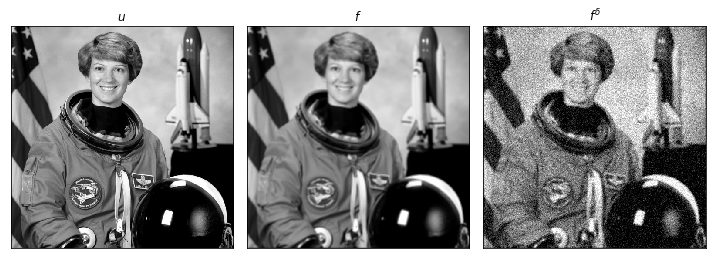

In [49]:
# read image
u = rgb2gray(data.astronaut())

# blur image
psf = np.ones((5, 5)) / 25
f = conv2(u, psf, 'same')

# add_noise
delta = 0.01
f_delta = random_noise(f, var = delta, clip=False)

# plot
plot_images([u, f, f_delta], [r'$u$', r'$f$', r'$f^\delta$'], 'example1.png')

# A typical Inverse Problem ...

![](example1.png)

# Overview

* Inverse Problems
* Regularisation
* Sparse regularisation
* Data-driven regularisation

# Inverse problems in imaging

* $K$ - forward operator (convolution with PSF)
* $u$ - image (function or 2D array representing RGB values or intensity)
* $f$ - noiseless measurements ($f = Ku$)
* $f^\delta$ - noisey measurements ($f^\delta = f + \epsilon$ for additive noise)

> The goal is to retrieve $u$ given $K$ and $f^\delta$

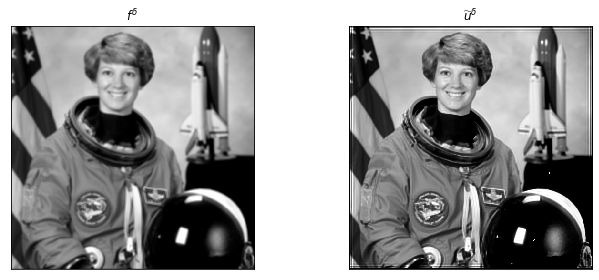

In [63]:
# read image
u = rgb2gray(data.astronaut())

# blur image
psf = np.ones((5, 5)) / 25
f = conv2(u, psf, 'same')

# add_noise
delta = 1e-16
f_delta = random_noise(f, var = delta, clip=False)

# inverse
u_est = richardson_lucy(f_delta, psf, iterations=30, clip=False) 

# plot
plot_images([f_delta, u_est], [r'$f^\delta$', r'$\widetilde{u}^\delta$'], fname='decon_' + str(delta) + '.png')

We can naively retrieve the solution via deconvolution

$$\widetilde{u}^\delta = \mathcal{F}^{-1}\left(\frac{\widehat{f}^\delta}{\widehat{k}}\right).$$


This will amplify noise at frequencies for which $\widehat{k}$ is small

## $\delta = 0$
![](decon_1e-16.png)

## $\delta = 10^{-6}$
![](decon_1e-06.png)

## $\delta = 10^{-3}$
![](decon_0.001.png)

# Regularisation

To avoid amplification of noise, we need to regularise the inverse filter.

Wiener filter:

$$\widetilde{u}^\delta_\alpha = \mathcal{F}^{-1} \left(\frac{\widehat{k}^*\widehat{f}^\delta}{|\widehat{k}|^2 + \alpha |\widehat{r}|^2}\right),$$

where $\widehat{r}$ is the psf of the regularistation operator.

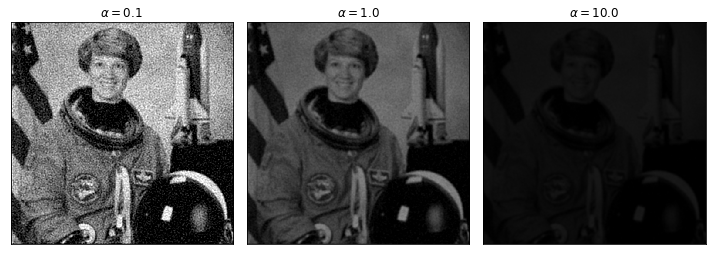

In [75]:
# read image
u = rgb2gray(data.astronaut())

# blur image
psf = np.ones((5, 5)) / 25
f = conv2(u, psf, 'same')

# add_noise
f_delta = random_noise(f, var = 0.01, clip=False)

# regularisation
reg_psf = np.zeros((5,5))
reg_psf[2,2] = 1

# apply inverse
alphas = [.1, 1.0, 10.0]
u_est = [0,0,0]
titles = [0,0,0]
for k in range(3):
    u_est[k] = wiener(f_delta, psf, reg = reg_psf, balance=alphas[k], clip=False) 
    titles[k] = r'$\alpha = $' + str(alphas[k])
# 
plot_images(u_est, titles, fname='decon_reg_id.png')

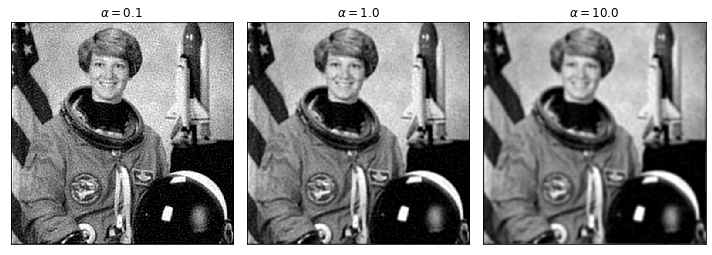

In [76]:
# read image
u = rgb2gray(data.astronaut())

# blur image
psf = np.ones((5, 5)) / 25
f = conv2(u, psf, 'same')

# add_noise
f_delta = random_noise(f, var = 0.01, clip=False)

# regularisation
reg_psf = np.array([[0,1,0],[1,-4,1],[0,1,0]])

# apply inverse
alphas = [.1, 1.0, 10.0]
u_est = [0,0,0]
titles = [0,0,0]
for k in range(3):
    u_est[k] = wiener(f_delta, psf, reg = reg_psf, balance=alphas[k], clip=False) 
    titles[k] = r'$\alpha = $' + str(alphas[k])
# 
plot_images(u_est, titles, fname='decon_reg_lap.png')

## $|\widehat{r}|^2 = 1$

![](decon_reg_id.png)

## $|\widehat{r}|^2 = |\xi|^2$

![](decon_reg_lap.png)

## Bias-variance trade-off

Regularisation reduces the influence of noise but introduces a bias.

$$\|u^\delta_\alpha - u\| \leq \|u^0_\alpha - u\| + \|u^\delta_\alpha - u^0_\alpha\|.$$

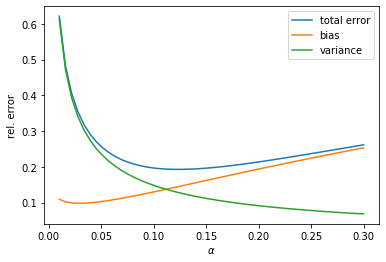

In [89]:
# read image
u = rgb2gray(data.astronaut())

# blur image
psf = np.ones((5, 5)) / 25
f = conv2(u, psf, 'same')

# add_noise
f_delta = random_noise(f, var = 0.01, clip=False)

# regularisation
reg_psf = np.array([[0,0,0],[0,1,0],[0,0,0]])

# apply inverse
ns = 50
alphas = np.linspace(.01,.3,ns)
error = np.zeros(ns)
bias = np.zeros(ns)
variance = np.zeros(ns)
for k in range(ns):
    u_delta_alpha = wiener(f_delta, psf, reg = reg_psf, balance=alphas[k], clip=False) 
    u_0_alpha = wiener(f, psf, reg = reg_psf, balance=alphas[k], clip=False)
    
    error[k] = np.linalg.norm(u_delta_alpha - u)/np.linalg.norm(u)
    bias[k] = np.linalg.norm(u_0_alpha - u)/np.linalg.norm(u)
    variance[k] = np.linalg.norm(u_0_alpha - u_delta_alpha)/np.linalg.norm(u)
# 
plt.plot(alphas,error,label='total error')
plt.plot(alphas,bias,label='bias')
plt.plot(alphas,variance,label='variance')
plt.legend()
plt.xlabel(r'$\alpha$')
plt.ylabel('rel. error')
plt.savefig('bias_variance.png',dpi=300)

![](bias_variance.png)

## A variational framework

The above-mentioned regularisation methods can be cast as a least-squares problem

$$\min_u \frac{1}{2\delta^2}\|Ku - f^\delta\|^2 + \frac{1}{2\lambda^2} \|Ru\|^2,$$

with $\alpha = (\delta / \lambda)^2$.

This quadratic problem has a closed-form solution

$$\widetilde{u}^\delta_\alpha = \left(K^*\!K + \alpha R^*\!R\right)^{-1}K^*f^\delta.$$

## A statistical interpretation

The solution can be interpreted as the most likely one, under the assumption that 

* $f^\delta = Ku + \epsilon$, with $\epsilon \sim \mathcal{N}(0,\delta^2)$
* $u \sim \mathcal{N}(0,\lambda (R^*\!R)^{-1})$.

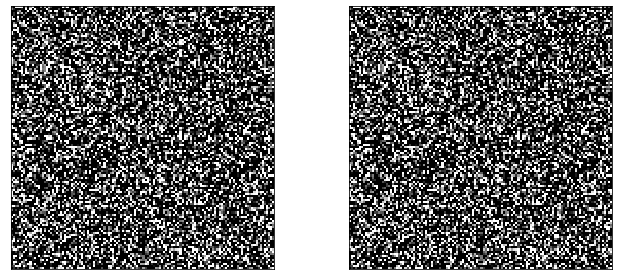

In [93]:
n = 128

# regularisation
reg_psf = np.array([[0,1,0],[1,-4,1],[0,1,0]])

# random image with unit covariance
u1 = np.random.randn(n,n)

# random image with inverse Laplace covariance
#u2 = wiener(np.random.randn(n,n), reg_psf, reg = 1, balance=1e-16, clip=False) 

#
plot_images([u1,u1], ['',''], fname='bayesian.png')

In [91]:
help(np.random.randn)

Help on built-in function randn:

randn(...) method of numpy.random.mtrand.RandomState instance
    randn(d0, d1, ..., dn)
    
    Return a sample (or samples) from the "standard normal" distribution.
    
    .. note::
        This is a convenience function for users porting code from Matlab,
        and wraps `standard_normal`. That function takes a
        tuple to specify the size of the output, which is consistent with
        other NumPy functions like `numpy.zeros` and `numpy.ones`.
    
    .. note::
        New code should use the ``standard_normal`` method of a ``default_rng()``
        instance instead; see `random-quick-start`.
    
    If positive int_like arguments are provided, `randn` generates an array
    of shape ``(d0, d1, ..., dn)``, filled
    with random floats sampled from a univariate "normal" (Gaussian)
    distribution of mean 0 and variance 1. A single float randomly sampled
    from the distribution is returned if no argument is provided.
    
    Paramete